In [1]:
import matplotlib
%matplotlib qt
import scipy
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy import signal, misc, interpolate
from skimage.feature import corner_harris, peak_local_max
from skimage.color import rgb2gray
from skimage import io
import numpy as np
from numpy import random
from PIL import Image
import cv2

In [2]:
def find_points(im, total=4):
    plt.imshow(im)
    im_points = []
    for i in range(total):
        point = plt.ginput(1, timeout = 0, show_clicks=True)
        plt.scatter(point[0][0], point[0][1])
        im_points.append([point[0][0], point[0][1]])
    plt.close()
    return np.array(im_points)

In [3]:
h1 = plt.imread("H1.jpg")
# h1_pts = find_points(h1, 4)
h1_pts = np.array([[125.63686534,  71.11147903],
       [258.08719647,  75.52649007],
       [ 99.14679912, 386.78476821],
       [253.67218543, 393.40728477]])

In [4]:
h2 = plt.imread("H2.jpg")
# h2_pts = find_points(h2, 4)
h2_pts = np.array([[ 79.27924945,  57.86644592],
       [196.27704194,  49.03642384],
       [152.12693157, 331.59713024],
       [293.40728477, 294.06953642]])

In [5]:
h1_pts = np.roll(h1_pts, 1, axis=1)
h2_pts = np.roll(h2_pts, 1, axis=1)

In [6]:
def computeMatrix(im1_pts, im2_pts):
    z = np.zeros((im1_pts.shape[0], 3))
    x_y_1 = np.hstack((im1_pts, np.ones((im1_pts.shape[0],1))))
    
    A = np.vstack((np.hstack((x_y_1, z, np.array([(-1)*im1_pts[:, 0] * im2_pts[:, 0]]).T, 
                     np.array([(-1)*im1_pts[:, 1] * im2_pts[:, 0]]).T)), 
                   np.hstack((z, x_y_1, np.array([(-1)*im1_pts[:, 0] * im2_pts[:, 1]]).T, 
                     np.array([(-1)*im1_pts[:, 1] * im2_pts[:, 1]]).T))))
    Pprime = np.vstack((im2_pts[:,0][..., None], im2_pts[:,1][..., None]))
 
    return np.append(np.linalg.lstsq(A, Pprime)[0],[1]).reshape((3,3))

<ipython-input-6-4561fa1d0661>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.append(np.linalg.lstsq(A, Pprime)[0],[1]).reshape((3,3))


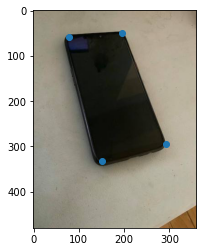

In [7]:
%matplotlib inline
plt.imshow(h2)
point = computeMatrix(h1_pts, h2_pts) @ np.vstack((h1_pts.transpose(), np.ones((h1_pts.shape[0]), dtype=int)))
point = (point[:2] / point[2]).T
plt.scatter(point[:,1], point[:,0])
plt.draw()  

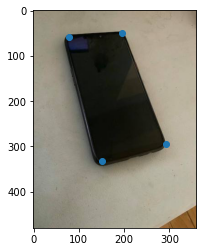

In [8]:
%matplotlib inline
plt.imshow(h2)
hako = np.vstack((h2_pts.transpose(), np.ones((h2_pts.shape[0]), dtype=int)))[:2].transpose()
plt.scatter(hako[:,1], hako[:,0])
plt.draw()

In [9]:
def warper(im, matrix):
    im = im[:, :, :3]
    pts = np.vstack((np.mgrid[0:im[:,:,0].shape[0], 0:im[:,:,0].shape[1]][0].ravel(), 
                     np.mgrid[0:im[:,:,0].shape[0], 0:im[:,:,0].shape[1]][1].ravel()))
    point = matrix @ np.vstack((pts, np.ones((pts.shape[1],))))
    pts_result = point[:2]/ point[2]
    
    maxx = max(pts_result[0, :])
    minx = min(pts_result[0, :])
    maxy = max(pts_result[1, :])
    miny = min(pts_result[1, :])

    x = maxx + (-1)*minx
    y = maxy + (-1)*miny
    warpped_im = np.zeros((x.astype(np.int)+1, y.astype(np.int)+1, 3))
    
    pts = np.vstack((np.mgrid[0:x, 0:y][0].ravel(), np.mgrid[0:x, 0:y][1].ravel()))
    pts[0, :] = pts[0, :] + minx
    pts[1, :] = pts[1, :] + miny

    point = (np.linalg.inv(matrix) @ np.vstack((pts, np.ones((pts.shape[1],)))))
    pts_result = (point[:2]/point[2])
    
    maskX = np.logical_and(pts_result[0, :] >= 0, pts_result[0, :] < im[:,:,0].shape[0])
    pts_result = pts_result[:,maskX]
    pts = pts[:,maskX]
    
    maskY = np.logical_and(pts_result[1, :] >= 0, pts_result[1, :] < im[:,:,0].shape[1])
    pts_result = pts_result[:,maskY]
    pts = pts[:,maskY]

    pts[0, :] = pts[0, :] - minx
    pts[1, :] = pts[1, :] - miny

    warpped_im[pts[0,:].astype(np.int), pts[1,:].astype(np.int)] = im[pts_result[0,:].astype(np.int), pts_result[1,:].astype(np.int)]
    
    return [minx, miny], warpped_im

<ipython-input-6-4561fa1d0661>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.append(np.linalg.lstsq(A, Pprime)[0],[1]).reshape((3,3))


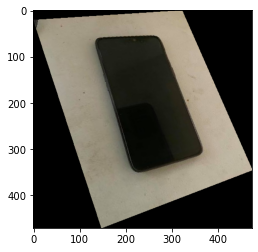

In [10]:
%matplotlib inline
H = computeMatrix(h1_pts, h2_pts)
_, im = warper(h1, H)
plt.imshow(im.astype(np.uint8))
plt.savefig("warp.jpg")

<ipython-input-6-4561fa1d0661>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.append(np.linalg.lstsq(A, Pprime)[0],[1]).reshape((3,3))


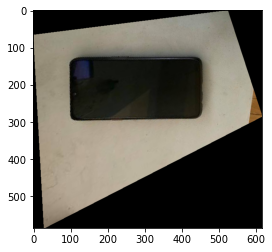

In [11]:
%matplotlib inline
chosen_sq = np.array([[100, 60], [250, 60], [100, 400], [250, 400]])
_, im = warper(h2, computeMatrix(h2_pts, chosen_sq))
plt.imshow(im.astype(np.uint8))
plt.savefig("h2_rectangle.jpg")

In [12]:
im0 = plt.imread("mosaic1.jpg")
im1 = plt.imread("mosaic2.jpg")

In [13]:
def get_harris_corners(im, edge_discard=20):
    assert edge_discard >= 20

    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, indices=True)

    edge = edge_discard
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords

def dist2(x, c):
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-13-8d79a8f9dd07>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


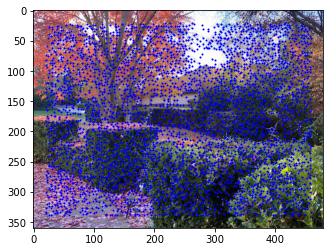

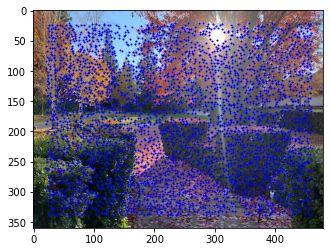

In [14]:
%matplotlib inline
testIm1 = rgb2gray(im0)
h, coords = get_harris_corners(testIm1)
testIm2 = rgb2gray(im1)
h2, coords2 = get_harris_corners(testIm2)
plt.imshow(im0)
plt.scatter(coords[1,:], coords[0,:], s=1, c="blue")
plt.show()
plt.imshow(im1)
plt.scatter(coords2[1,:], coords2[0,:], s=1, c="blue")

In [15]:
def suppression(coords, matrix):
    pts = []
    for i in range(coords.shape[1]):
        pts.append((list(coords[:,i]), matrix[coords[0,i], coords[1,i]]))
    points = np.array([x[0] for x in np.sort(np.array(pts, dtype=[('coord', list), ('R', float)]), order='R')[::-1]])
    radius = list(np.max(np.triu(dist2(points, points), k=0), axis=1))
    return np.array([x[0] for x in np.sort(np.array(pts, dtype=[('coord', list), ('R', float)]), order='R')[::-1]])

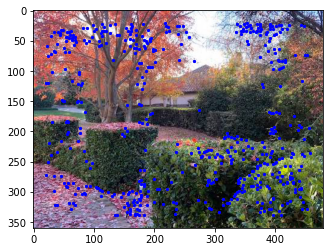

In [16]:
filter1 = suppression(coords, h)[:500].T
plt.imshow(im0)
plt.scatter(filter1[1,:], filter1[0,:], s=5, c="blue")
plt.draw()

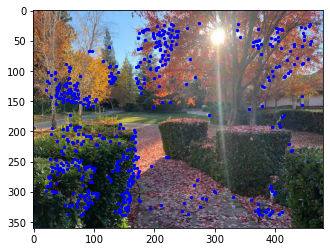

In [17]:
filter2 = suppression(coords2, h2)[:500].T
plt.imshow(im1)
plt.scatter(filter2[1,:], filter2[0,:], s=5, c="blue")
plt.draw()

In [18]:
def feature(pts, im):
    im = im[:,:,0]
    im = cv2.blur(im,(5,5))
    feature = []
    for i in range(pts.shape[1]):
        mod_im = im[pts[:,i][0] - 20:pts[:,i][0] + 20:5, pts[:,i][1] - 20:pts[:,i][1] + 20:5]
        patch = (mod_im - mod_im.mean()) / mod_im.std()
        feature.append(patch.flatten())
    return feature

In [19]:
feature1 = np.array(feature(filter1, im0))
feature2 = np.array(feature(filter2, im1))

In [20]:
def mapper(point1, filter1, point2, filter2):
    dist_mat = dist2(point1, point2)
    ind = np.argsort(dist_mat, axis=0)
    rad = np.sort(dist_mat, axis=0)
    rat = rad[0] / rad[1]
    filtered = [i for i in range(len(rat)) if rat[i] < 0.5]
    return filter1[:,ind[0,filtered]], filter2[:,filtered]

def ransac(feature1, feature2):
    bestIn = 0
    for i in range(1000):
        inx_random = random.permutation(range(feature1.shape[1]))[:4]
        pair1 = feature1[:,inx_random].T
        pair2 = feature2[:,inx_random].T
        matrix = computeMatrix(pair1, pair2)
        point = ((matrix @ np.vstack((feature1, np.ones((feature1.shape[1])))))[:2] / (matrix @ np.vstack((feature1, np.ones((feature1.shape[1])))))[2])
        dist = np.linalg.norm(feature2 - point, axis=0)
        indices = np.where(dist < 1)[0]
        if (len(indices)) > bestIn:
            in1 = feature1[:,indices]
            in2 = feature2[:,indices] 
            bestIn = len(indices)
    in1_t = np.roll(in1, 1, axis=1)
    in2_t = np.roll(in2, 1, axis=1)
    H = computeMatrix(in1_t.T, in2_t.T)
    return in1, in2, H

<ipython-input-6-4561fa1d0661>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.append(np.linalg.lstsq(A, Pprime)[0],[1]).reshape((3,3))


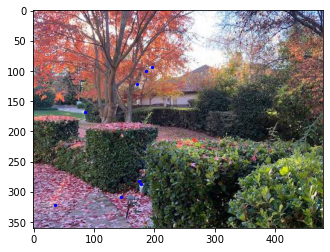

In [21]:
feature1, feature2 = mapper(feature1, filter1, feature2, filter2)
in1, in2, H = ransac(feature1, feature2)
plt.imshow(im0)
plt.scatter(in1[1,:], in1[0,:], s=5, c="blue")

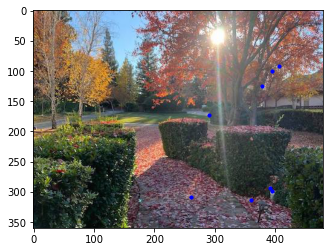

In [22]:
plt.imshow(im1)
plt.scatter(in2[1,:], in2[0,:], s=10, c="blue")

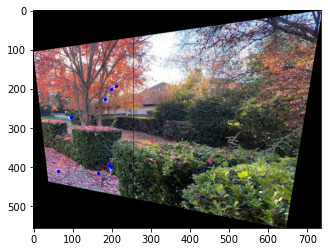

In [23]:
off, im = warper(im0, H)
matrix = np.vstack((in1, np.ones((in1.shape[1],))))
pts_result = ((H @ matrix)[:2] / (H @ matrix)[2])
pts_result[0, :] = pts_result[0, :] - off[0]
pts_result[1, :] = pts_result[1, :] - off[1]
plt.imshow(im.astype(np.uint8))
plt.scatter(pts_result[1,:], pts_result[0,:], s=5, c="blue")

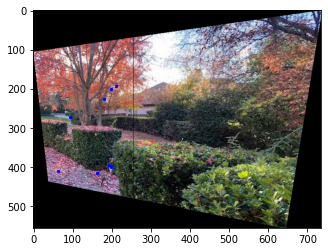

In [24]:
in2[0, :] = in2[0, :] - off[0]
in2[1, :] = in2[1, :] - off[1]

plt.imshow(im.astype(np.uint8))
plt.scatter(in2[1,:], in2[0,:], s=5, c="blue")

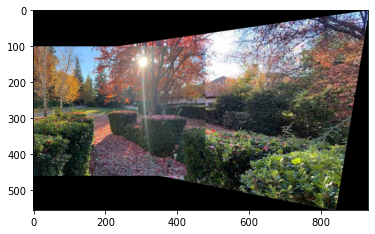

In [26]:
def stitch(im1, im2, offset):
    h_im1 = im1.shape[0]
    w_im1 = im1.shape[1]
    h_im2 = im2.shape[0]
    w_im2 = im2.shape[1]
    h_offset = int(offset[0])
    w_offset = int(offset[1])
    max_h = max(h_im1, h_im2)
    max_w = max(w_im1, w_im2)
    
    if w_offset < 0:
        new_w = w_im2 - w_offset
        w_start = 0
        w_end = w_im1
        w_start_2 = -w_offset
        w_end_2 = new_w
    else:
        new_w = w_im1 + w_offset
        w_start = w_offset
        w_end = new_w
        w_start_2 = 0
        w_end_2 = w_im2
    if h_offset < 0:
        new_h = h_im2 - h_offset
        h_im1_start = 0
        h_im1_end = h_im1
        h_im2_start = -h_offset
        h_im2_end = new_h
    else:
        new_h = h_warpped + h_offset
        h_im1_start = h_offset
        h_im1_end = new_h
        h_im2_start = 0
        h_im2_end = h_im2
    stitch_im = np.zeros((int(max(new_h, max_h)), int(max(new_w, max_w)), 3))
    stitch_im[h_im1_start:h_im1_end, w_start:w_end] = im1
    stitch_im[h_im2_start:h_im2_end, w_start_2:w_end_2] = im2
    plt.imsave("outdoor_stitch.jpg", stitch_im.astype(np.uint8))
    plt.imshow(stitch_im.astype(np.uint8))  

stitch(im, im1, off)